In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%%capture
%cd drive/MyDrive/genrecog/
%pip install speechbrain
%pip install torchlibrosa

In [3]:
from genrecog.preprocess.preprocessor import Preprocessor
from genrecog.nnet.RNN import GRU
from genrecog.tools.trainer import RNNFbankTrainer
import torch
from torch.utils.data import TensorDataset, DataLoader 
import datetime

torch.manual_seed(0)

In [4]:
# Load dataset

train_preprcessor = Preprocessor('dataset/npz_files/train.npz')
test_preprcessor = Preprocessor('dataset/npz_files/test.npz')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
X, y = train_preprcessor.as_shuffled_torch()
X_test, y_test = test_preprcessor.as_shuffled_torch()

dataset = TensorDataset(X.to(device), y.to(device))
validation_dataset, train_dataset = torch.utils.data.random_split(dataset, (400, 3200))
test_dataset = TensorDataset(X_test.to(device), y_test.to(device))

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=400)
validation_dataloader = DataLoader(validation_dataset, shuffle=True, batch_size=400)
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=400)

In [6]:
hidden_size = 128
num_layers = 5
input_size = 40
output_dim = 10
time_sequence = 702
lr = 0.001
model = GRU(
    input_size=input_size, 
    time_sequence=time_sequence,
    hidden_size=hidden_size, 
    num_layers=num_layers, 
    output_dim=output_dim,
    use_mean=True
    ).to(device)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
model

GRU(
  (batch_norm_input): BatchNorm1d(702, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (glu): GRU(40, 128, num_layers=5, batch_first=True)
  (batch_norm_hidden): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear): Linear(in_features=128, out_features=10, bias=True)
)

In [7]:
trainer = RNNFbankTrainer(
    model=model, 
    optimizer=optimizer, 
    loss=loss, 
    train_dataloader=train_dataloader, 
    validation_dataloader=validation_dataloader, 
    num_epochs=100)
trainer.train()

============================== EPOCH 1 =================================
Training accuracy 33.59
Training loss 1.8366
Validation accuracy 21.25
Validation loss 2.2553
============================== EPOCH 2 =================================
Training accuracy 44.62
Training loss 1.5291
Validation accuracy 23.00
Validation loss 2.1049
============================== EPOCH 3 =================================
Training accuracy 49.72
Training loss 1.4140
Validation accuracy 43.00
Validation loss 1.8794
============================== EPOCH 4 =================================
Training accuracy 53.06
Training loss 1.3239
Validation accuracy 51.00
Validation loss 1.7084
============================== EPOCH 5 =================================
Training accuracy 56.06
Training loss 1.2423
Validation accuracy 61.00
Validation loss 1.5058
============================== EPOCH 6 =================================
Training accuracy 60.19
Training loss 1.1549
Validation accuracy 53.25
Validation loss 1.340

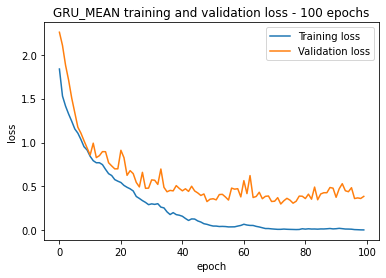

In [8]:
trainer.plot_loss("GRU_MEAN training and validation loss - 100 epochs")

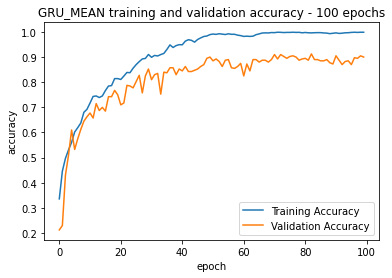

In [9]:
trainer.plot_accuracies("GRU_MEAN training and validation accuracy - 100 epochs")

In [10]:
trainer.eval(test_dataloader)

(tensor([6, 3, 9, 7, 9, 1, 7, 4, 3, 7, 3, 7, 5, 5, 6, 6, 2, 6, 1, 0, 9, 4, 4, 5,
         5, 6, 6, 1, 4, 8, 4, 4, 4, 1, 3, 5, 8, 6, 2, 3, 2, 0, 9, 8, 9, 2, 8, 5,
         2, 5, 8, 6, 4, 3, 1, 2, 4, 8, 0, 9, 2, 9, 4, 5, 4, 8, 6, 1, 9, 3, 6, 5,
         9, 6, 6, 9, 8, 7, 8, 5, 3, 8, 2, 6, 7, 4, 8, 3, 5, 7, 3, 0, 8, 3, 4, 8,
         4, 7, 2, 5, 8, 3, 0, 3, 0, 9, 6, 8, 7, 6, 1, 5, 1, 2, 4, 4, 8, 9, 1, 6,
         6, 5, 3, 0, 5, 6, 2, 6, 5, 4, 0, 4, 6, 9, 2, 7, 8, 6, 6, 2, 0, 0, 7, 9,
         7, 5, 4, 6, 7, 2, 8, 1, 3, 0, 2, 0, 0, 9, 8, 7, 7, 0, 4, 3, 3, 3, 6, 8,
         8, 7, 0, 8, 2, 4, 0, 8, 8, 9, 3, 9, 8, 6, 7, 2, 4, 2, 5, 0, 3, 0, 9, 7,
         6, 0, 9, 6, 0, 9, 9, 1, 3, 0, 3, 9, 3, 4, 6, 1, 7, 8, 0, 2, 0, 2, 0, 7,
         4, 8, 6, 0, 9, 0, 9, 9, 9, 5, 9, 5, 0, 3, 3, 8, 6, 3, 3, 1, 0, 2, 6, 6,
         4, 0, 7, 9, 3, 0, 6, 8, 2, 9, 0, 5, 7, 7, 4, 1, 2, 4, 6, 8, 5, 9, 6, 3,
         0, 8, 2, 5, 2, 3, 7, 1, 2, 0, 0, 4, 4, 0, 8, 6, 9, 0, 0, 6, 2, 7, 2, 7,
         2, 9, 8, 0, 3, 2, 0

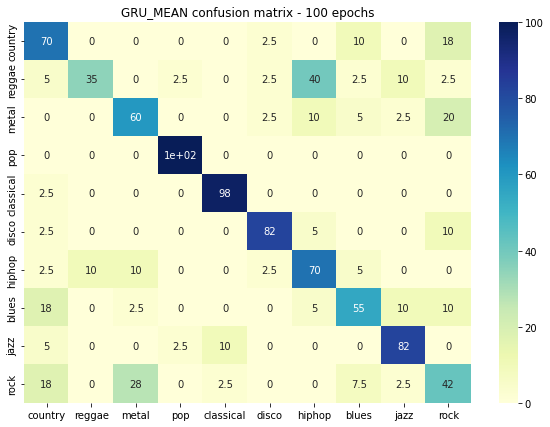

In [11]:
trainer.plot_confusion_matrix(test_dataloader, "GRU_MEAN confusion matrix - 100 epochs")

In [12]:
trainer.classification_report(test_dataloader)

              precision    recall  f1-score   support

     country       0.57      0.70      0.63        40
      reggae       0.78      0.35      0.48        40
       metal       0.60      0.60      0.60        40
         pop       0.95      1.00      0.98        40
   classical       0.89      0.97      0.93        40
       disco       0.89      0.82      0.86        40
      hiphop       0.54      0.70      0.61        40
       blues       0.65      0.55      0.59        40
        jazz       0.77      0.82      0.80        40
        rock       0.41      0.42      0.42        40

    accuracy                           0.69       400
   macro avg       0.70      0.69      0.69       400
weighted avg       0.70      0.69      0.69       400



In [13]:
hidden_size = 128
num_layers = 5
input_size = 40
output_dim = 10
time_sequence = 702
lr = 0.001
model_2 = GRU(
    input_size=input_size, 
    time_sequence=time_sequence,
    hidden_size=hidden_size, 
    num_layers=num_layers, 
    output_dim=output_dim,
    use_mean=True
    ).to(device)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr=lr)
model_2

GRU(
  (batch_norm_input): BatchNorm1d(702, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (glu): GRU(40, 128, num_layers=5, batch_first=True)
  (batch_norm_hidden): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear): Linear(in_features=128, out_features=10, bias=True)
)

In [14]:
trainer_2 = RNNFbankTrainer(
    model=model_2, 
    optimizer=optimizer, 
    loss=loss, 
    train_dataloader=train_dataloader, 
    validation_dataloader=validation_dataloader, 
    num_epochs=70)
trainer_2.train()

============================== EPOCH 1 =================================
Training accuracy 31.91
Training loss 1.8314
Validation accuracy 10.50
Validation loss 2.2705
============================== EPOCH 2 =================================
Training accuracy 44.44
Training loss 1.5339
Validation accuracy 20.25
Validation loss 2.1280
============================== EPOCH 3 =================================
Training accuracy 49.97
Training loss 1.4115
Validation accuracy 36.25
Validation loss 1.9405
============================== EPOCH 4 =================================
Training accuracy 52.91
Training loss 1.3323
Validation accuracy 49.00
Validation loss 1.7052
============================== EPOCH 5 =================================
Training accuracy 55.94
Training loss 1.2614
Validation accuracy 53.75
Validation loss 1.4765
============================== EPOCH 6 =================================
Training accuracy 58.37
Training loss 1.1919
Validation accuracy 46.25
Validation loss 1.412

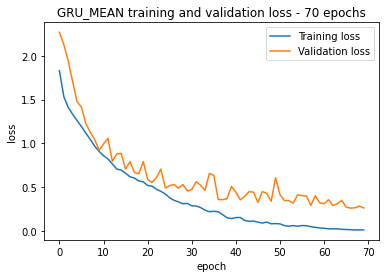

In [15]:
trainer_2.plot_loss("GRU_MEAN training and validation loss - 70 epochs")

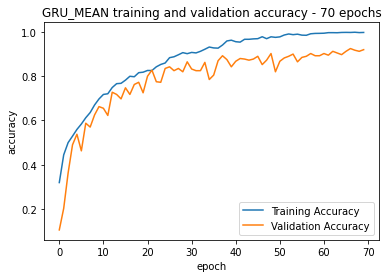

In [16]:
trainer_2.plot_accuracies("GRU_MEAN training and validation accuracy - 70 epochs")

In [17]:
trainer_2.eval(test_dataloader)

(tensor([9, 3, 9, 7, 0, 4, 6, 9, 9, 6, 4, 2, 4, 6, 2, 2, 8, 3, 5, 9, 9, 6, 4, 4,
         1, 4, 2, 9, 9, 8, 7, 4, 7, 5, 8, 8, 0, 5, 2, 2, 0, 6, 7, 5, 6, 6, 0, 3,
         7, 3, 7, 8, 1, 0, 8, 1, 2, 3, 6, 8, 4, 4, 5, 4, 2, 8, 7, 4, 3, 3, 2, 0,
         4, 8, 0, 0, 1, 6, 0, 3, 2, 9, 2, 4, 9, 4, 4, 4, 9, 6, 6, 8, 0, 2, 8, 8,
         6, 4, 2, 4, 3, 7, 2, 3, 8, 2, 0, 5, 8, 0, 9, 0, 0, 5, 0, 0, 7, 8, 2, 2,
         6, 4, 5, 6, 2, 1, 5, 9, 5, 3, 5, 0, 8, 4, 6, 5, 8, 4, 2, 1, 1, 8, 3, 5,
         9, 0, 7, 5, 5, 6, 6, 5, 7, 5, 1, 9, 6, 8, 1, 3, 1, 0, 4, 6, 9, 5, 6, 4,
         7, 2, 6, 0, 8, 1, 8, 1, 4, 5, 9, 6, 9, 9, 1, 1, 4, 8, 9, 7, 7, 0, 0, 1,
         1, 8, 6, 4, 9, 9, 2, 9, 3, 8, 7, 8, 7, 6, 9, 9, 8, 3, 0, 5, 7, 5, 3, 3,
         3, 3, 4, 9, 2, 5, 3, 2, 7, 0, 5, 7, 6, 1, 9, 9, 4, 9, 2, 2, 4, 0, 5, 0,
         4, 1, 2, 8, 1, 8, 6, 0, 2, 4, 5, 6, 9, 1, 9, 7, 2, 4, 0, 9, 5, 7, 1, 7,
         7, 4, 0, 4, 0, 6, 4, 4, 7, 0, 7, 2, 9, 2, 3, 5, 5, 3, 9, 7, 5, 3, 2, 9,
         1, 8, 6, 3, 6, 9, 3

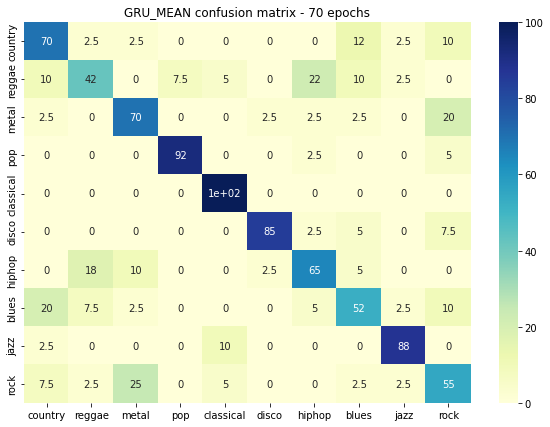

In [18]:
trainer_2.plot_confusion_matrix(test_dataloader, "GRU_MEAN confusion matrix - 70 epochs")

In [19]:
trainer_2.classification_report(test_dataloader)

              precision    recall  f1-score   support

     country       0.62      0.70      0.66        40
      reggae       0.59      0.42      0.49        40
       metal       0.64      0.70      0.67        40
         pop       0.93      0.93      0.93        40
   classical       0.83      1.00      0.91        40
       disco       0.94      0.85      0.89        40
      hiphop       0.65      0.65      0.65        40
       blues       0.58      0.53      0.55        40
        jazz       0.90      0.88      0.89        40
        rock       0.51      0.55      0.53        40

    accuracy                           0.72       400
   macro avg       0.72      0.72      0.72       400
weighted avg       0.72      0.72      0.72       400

